(3site-cycle-fin-nb)=
# 1D cycle of 1D finite tight-binding model

This example considers a simple three-site one-dimensional tight-binding
model parametrized by some parameter $\lambda$. As $\lambda$
is changed from 0 to 1, the deepest onsite term is moved from the first
to second, then to the third, and then back to the first tight-binding
orbital. Therefore, we expect that Wannier center of the lowest band will
shift by one lattice vector as $\lambda$ changes from 0 to 1.

Also plots the individual on-site energies, band structure, and Wannier
center of lowest band.

In [1]:
from pythtb import TBModel, WFArray, Mesh
import numpy as np
import matplotlib.pyplot as plt

Define function to construct model

In [2]:
def set_model(t, delta, lmbd):
    lat = [[1]]
    orb = [[0], [1/3], [2/3]]
    model = TBModel(1, 1, lat, orb)
    model.set_hop(t, 0, 1, [0])
    model.set_hop(t, 1, 2, [0])
    model.set_hop(t, 2, 0, [1])
    onsite_0 = delta * -np.cos(2*np.pi * (lmbd - 0/3))
    onsite_1 = delta * -np.cos(2*np.pi * (lmbd - 1/3))
    onsite_2 = delta * -np.cos(2*np.pi * (lmbd - 2/3))
    model.set_onsite([onsite_0, onsite_1, onsite_2])
    return model

## `Mesh` and `WFArray`

Next, we construct the `Mesh` object for a 1D parameter path and 1D k-space. 

When using a parameter space with the mesh, we must define a model building function as we've done above. The model parameters are defined by the arguments of the function. Some of these arguments may be fixed, while others may vary. 

:::{warning}
The argument that we plan to vary must be named appropriately in the mesh via the `axis_names` argument in the `Mesh` constructor. If the name of the model parameter we are varying does not match the corresponding axis name in the mesh, the parameter will not be varied correctly. Here we are varying the `lmbd` parameter.
:::

In [ ]:
mesh = Mesh(
    dim_k=1, dim_param=1, axis_types=["k", "param"], axis_names=["kx", "lmbd"]
    )

We next populate the `Mesh` with grid points. To do so, we use the `build_full_grid` helper function, specifying the desired shape of the grid and whether to center it around the gamma point in k-space.

In [4]:
mesh.build_full_grid(shape=(31, 21), gamma_centered=True)

Now, we initialize the `WFArray` object with the mesh we created. To solve the tight-binding model on this mesh, we can use `solve_mesh`. 

In the situation where one of the axes in the mesh is a model parameter, we need to pass the function that returns the model given the set of parameters, and optionally the function arguments that we keep fixed.

::: {warning}
Once again, the names matter here as well. The keys in the `fixed_params` dictionary must match the names of the arguments in the model function exactly.
:::

In [ ]:
# Used for initializing the Mesh
ref_model = set_model(0,0,0)

wfa = WFArray(ref_model, mesh)

In [6]:
fixed_params = {"t": -1.3, "delta": 2.0}
wfa.solve_mesh(set_model, fixed_params)

Auto-imposing PBC in mesh direction 0 for k-component 0


In [7]:
wfa.shape

(31, 21, 3, 3)

:::{versionadded} 2.0.0
:::

To compute the Chern numbers, we will use the `WFArray.chern_num` method, which calculates the integrated Berry flux for a given set of bands and a specified plane in the Brillouin zone.

In [8]:
# compute integrated curvature
chern_0 = wfa.chern_num(state_idx=[0], plane=(0,1))
chern_1 = wfa.chern_num(state_idx=[1], plane=(0,1))
chern_2 = wfa.chern_num(state_idx=[2], plane=(0,1))
chern_01 = wfa.chern_num(state_idx=[0,1], plane=(0,1))
chern_012 = wfa.chern_num(state_idx=[0,1,2], plane=(0,1))

print("Chern numbers for rising fillings")
print(f"  Band  0     = {chern_0:5.2f}")
print(f"  Bands 0,1   = {chern_01:5.2f}")
print(f"  Bands 0,1,2 = {chern_012:5.2f}")
print("")
print("Chern numbers for individual bands")
print(f"  Band  0 = {chern_0:5.2f}")
print(f"  Band  1 = {chern_1:5.2f}")
print(f"  Band  2 = {chern_2:5.2f}")

Chern numbers for rising fillings
  Band  0     = -1.00
  Bands 0,1   =  1.00
  Bands 0,1,2 = -0.00

Chern numbers for individual bands
  Band  0 = -1.00
  Band  1 =  2.00
  Band  2 = -1.00


## Finite model

Here, we will define a new model function for the finite system. This function will take the model parameters as input and return the corresponding `TBModel`. In this case, it will be the same as before except we cut out a finite chain of the periodic model. We do this using the `TBModel.cut_piece` method, passing the number of unit cells and the direction in which to cut.

In [9]:
# length of chain, in unit cells
num_cells = 10
num_orb = 3 * num_cells

def finite_model_builder(t, delta, lmbd):
    model = set_model(t, delta, lmbd)
    model = model.cut_piece(num_cells, 0)
    return model

Here, we do the same thing as before to create the `Mesh`. 

:::{note}
The only difference now is we no longer have a k-axis since our model is finite. Notice that `axis_types` only contains the `param` axis.
:::

In the `shape` argument of `build_full_grid`, we only need to specify the size of the array of `lmbd` points. 

In [11]:
mesh = Mesh(dim_k=0, dim_param=1, axis_types=["param"], axis_names=["lmbd"])
mesh.build_full_grid(shape=(241,))

Same as before, we create the `WFArray` to store our states with the mesh, and use `solve_mesh` to populate the `WFArray` with the wave functions and energies.

In [13]:
ref_model = finite_model_builder(0, 0, 0)

wfa = WFArray(ref_model,mesh)
wfa.solve_mesh(model_func=finite_model_builder, fixed_params=fixed_params)

## Position expectation value

Getting the expectation value of the position operator is as simple as calling `WFArray.position_expectation(...)`. We only need to pass the real-space direction to compute the expectation value. This will return the expectation value for each state index, at each point in the mesh array.

In [14]:
x_expec = wfa.position_expectation(dir=0)

### Plot eigenvalues vs. $\lambda$

We will indicate the position expectation value by the size of the markers in the plot. Notice in the finite chain the appearance of gapless edge modes. This is topologically protected, as evident by the Chern numbers we calculated earlier in the bulk case. 

(0.0, 1.0)

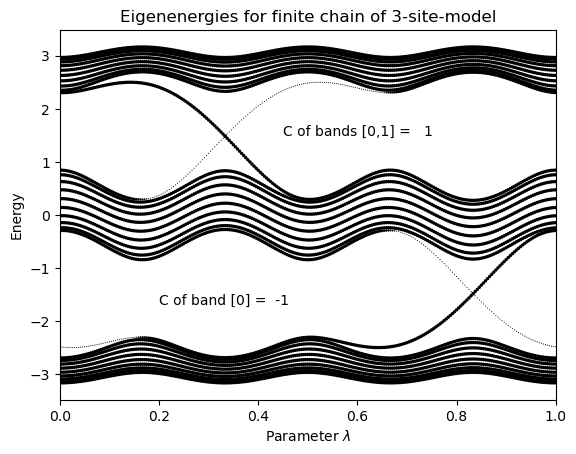

In [15]:
fig, ax = plt.subplots()

xcut = 2  # discard points below this
xfull = 4 # use symbols of full size above this

sizes = np.divide(
    x_expec - xcut,
    xfull - xcut,
    out=np.empty_like(x_expec, dtype=float),
    where=(xfull != xcut)
)

# clamp to [0.1, 1.0] in-place
np.clip(sizes, 0.1, 1.0, out=sizes)

all_lambda = mesh.get_param_points()
for o in range(num_orb):
    ax.scatter(all_lambda[:, 0], wfa.energies[:, o], edgecolors="none", s=sizes[:, o]*6.0, c="k")

# annotate gaps with bulk Chern numbers calculated earlier
ax.text(0.20, -1.7, f"C of band [0] = {chern_0:3.0f}")
ax.text(0.45, 1.5, f"C of bands [0,1] = {chern_01:3.0f}")

ax.set_title("Eigenenergies for finite chain of 3-site-model")
ax.set_xlabel(r"Parameter $\lambda$")
ax.set_ylabel("Energy")
ax.set_xlim(0.0, 1.0)